# DSI Assessment 2 - Quantified Self

In [147]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<b> 

Table of Contents:

* Part 1: Introduction
* Part 2: Collecting data
* Part 3: Text Pre-processing
* Part 4: Term Frequencies
* Part 5: Rugby and Term Co-Occurrences
* Part 6: Data Visualisation Basics
* Part 7: Sentiment Analysis Basics

</b>

## Part 1 Introduction

### Background

The purpose of this project is to gain insight into how we as individuals play a role in a collaborating on a data science endeavour. The data we will be collecting is the Slack chat conversations and JIRA issue tickets to get an understanding of the language used whilst collaborating. We will be using the CRISP-DM reference model for this data science project. A final report on our findings is to be presented.

#### Slack

## Part 2 Collecting Data

This part is about exporting the information and processing it in a matter which can be later processed and explored

In [1]:
import pandas as pd # Data Munging tool
import os # Operating System functionality
import glob # Finds all pathnames e.g(.json)
import re # Regular Expression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer # Combines both Count Vectorizer and Tfidf Transformer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

plt.style.use('ggplot')
%matplotlib inline

In [2]:
#users = pd.read_json("C:/users/Jared Chung/Desktop/D-Matrix/users.json") #Laptop
users = pd.read_json("C:/users/jchung/desktop/D-Matrix//users.json") #Work

In [41]:
#path_to_json = 'C:/users/Jared Chung/Desktop/D-Matrix/' #Laptop
path_to_json = 'C:/users/jchung/desktop/D-Matrix/' #Work
json_dir = os.listdir(path_to_json)
#del json_dir[0] ### do this step only if u have a mac and need to get rid of .DS Store folder
data = pd.DataFrame()
for file in json_dir:
    if "." not in file: 
        print (file)
        all_files = glob.glob(os.path.join(path_to_json + file + '/', "*.json"))
        df = pd.concat((pd.read_json(f) for f in all_files)) 
        df['channel'] = file
        df['ts'] = pd.to_datetime(df['ts'],unit='s')
        df2 = pd.DataFrame(df, columns = ['user','ts','channel','text'])
        data = data.append(df2)
    else:
        print "File contains extenstion"

36100-dsi
36100-dsi-photos
36103-statistics
36106-dam
File contains extenstion
File contains extenstion
crisp-businessknow
crisp-dataknow
crisp-dataprep
crisp-deploy
crisp-eval
crisp-modelling
dam
dsi
dsi-assignment-2a
general
File contains extenstion
jira-discussion
python_instructions
random
story-telling
File contains extenstion
File contains extenstion
File contains extenstion


## Part 3 Text Preprocessing

### Stemming and Lemmatizing

http://www.lnse.org/papers/134-I3007.pdf

D. A. Hull, “Stemming algorithms: A case study for detailed
evaluation,” Journal of the American Society for Information Science,
vol. 47, pp. 70-84, 1996.

One of the issues that arises in natural language processing is that words have morphligical variants which will not be recognised by term matching alogrithms (Hull 1996). This means you could have words like organize, organizes, and organizing all have the same meaning but won't be grouped together. 

Some of the techniques used to tackle this problem include Stemming and Lemmatizing


<b> Lemmatizing </b>



In [35]:
lemma = WordNetLemmatizer()

def lemma_tokens(tokens, lemma):
    lemmatized = []
    for item in tokens:
        lemmatized.append(lemma.lemmatize(item))
    return lemmatized

### Stopwords

Need to Paraphrase below

"""In every language, some words are particularly common. While their use in the language is crucial, they don’t usually convey a particular meaning, especially if taken out of context. This is the case of articles, conjunctions, some adverbs, etc. which are commonly called stop-words. In the example above, we can see three common stop-words – to, and and on. Stop-word removal is one important step that should be considered during the pre-processing stages. One can build a custom list of stop-words, or use available lists (e.g. NLTK provides a simple list for English stop-words)."""

In [15]:
stops = set(stopwords.words("english"))

In [62]:
def preprocessing(s):
    
    s = s.lower()
    # Howdy to English
    
    s = re.sub(r'<http://(d-matrix.)?howdy.ai/([a-zA-ez]+/)+([a-zA-Z]|[0-9])+[|]','',s,re.I)
    
    # Links to Text
    s = re.sub(r'((ht)|(f))tp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','Sharing a link!',s,
                  re.I)
    # Mail to Text
    s = re.sub(r'(mailto:)?[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+','Here is my email!',s,re.I)
    
    
    # Change Names for privacy
    s = s.replace('@u0weaa087|jared', 'DataScientist2')
    s = s.replace('@u0wdyeg6s|duhita', 'BusinessAnalyst')
    s = s.replace('@u0x443ckz|chris.garces', 'DataScientist1')
    s = s.replace('@u0wfhmem8|hussam', 'DataAnalyticsManager')
    s = s.replace('@u0x6cuq3d|martinlehmann', 'ProjectManager')
    
    s = s.replace('u0weaa087', 'DataScientist2')
    s = s.replace('u0wdyeg6s', 'BusinessAnalyst')
    s = s.replace('u0x443ckz', 'DataScientist1')
    s = s.replace('u0wfhmem8', 'DataAnalyticsManager')
    s = s.replace('u0x6cuq3d', 'ProjectManager')
    s = s.replace('u13aj8evd', 'BendertheScrumMaster')
    s = s.replace('howdy', 'BendertheScrumMaster')
    s = s.replace('duhita', 'BusinessAnalyst')
    s = s.replace('jared', 'DataScientist2')
    s = s.replace('martinlehmann', 'ProjectManager')
    s = s.replace('martin','ProjectManager')
    s = s.replace('hussam', 'DataAnalyticsManager')
    s = s.replace('chris', 'DataScientist1')
    s = s.replace('chris.garces', 'DataScientist1')
    s = s.replace('martinlehmann', 'ProjectManager')
    s = s.replace('ravi', 'Consultant')
    
    # Remove words that arent relevant
    s = s.replace("channel", "")
    s = s.replace("file", "")
    s = s.replace("link", "")
    
    # Remove everything that isnt a 
    s = re.sub(r'[^a-zA-Z]'," ",s)
    

    s = s.replace("  ", " ")
    
    word = s.split()
    
    word = [n for n in word if n not in stops]
    
    lemmas = lemma_tokens(word, lemma)
    
    return " ".join(lemmas)
    

In [130]:
data['clean_text'] = data.text.apply(lambda x: preprocessing(x))

In [121]:
data = pd.merge(data,users,left_on='user',right_on='id',how='inner')
data = data[['user','ts','channel','text','name']]

## Part 4 Term Frequency

In [138]:
#data[data.text.str.contains('@U13AJ8EVD')]
data.head()

,user,ts,channel,text,name,clean_text
0,U0WEAA087,2016-04-03 23:32:26.000002,36100-dsi,<@U0WEAA087|jared> has joined the channel,jared,DataScientist joined
1,U0WEAA087,2016-04-03 23:32:27.000003,36100-dsi,<@U0WEAA087|jared> set the channel purpose: Ch...,jared,DataScientist set purpose dedicated data scien...
2,U0WEAA087,2016-04-04 10:24:28.000009,36100-dsi,Yeah trying to get it done. I'm hoping to smas...,jared,yeah trying get done m hoping smash wednesday ...
3,U0WEAA087,2016-04-11 06:07:57.000119,36100-dsi,"Hey Guys, sorry haven't been that active. I'm ...",jared,hey guy sorry haven active m fine excel knime ...
4,U0WEAA087,2016-04-11 06:11:39.000120,36100-dsi,<http://nicomiceli.com/slackalytics/> I might ...,jared,Sharing might look


### Tokenizing

In [157]:
from collections import Counter
 

count_all = Counter()
for line in data[data.name == 'jared']['clean_text']:
    # Create a list with all the terms
    text = line.split()
    # Update the counter
    count_all.update(text)
    # Print the first 5 most frequent words
print(count_all.most_common(20))

[(u'DataScientist', 24), (u'yeah', 19), (u'word', 16), (u'm', 16), (u'joined', 15), (u'data', 15), (u'BendertheScrumMaster', 15), (u'hey', 15), (u'like', 14), (u'll', 12), (u'think', 12), (u'one', 11), (u'BusinessAnalyst', 11), (u'list', 9), (u'guy', 9), (u'would', 9), (u'quite', 9), (u'look', 9), (u'well', 9), (u'might', 8)]


(-0.5, 1799.5, 1399.5, -0.5)

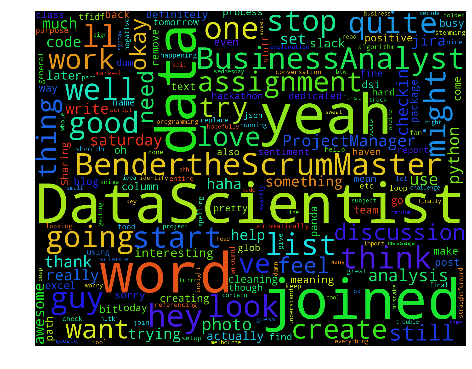

In [154]:
from wordcloud import WordCloud, STOPWORDS
words = ' '.join(data[data.name == 'jared']['clean_text'])

wordcloud = WordCloud(
                      #font_path='/Users/sebastian/Library/Fonts/CabinSketch-Bold.ttf',
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(words)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.imshow(wordcloud)
plt.axis('off')
#plt.savefig('./my_twitter_wordcloud_1.png', dpi=300)
#plt.show()

In [32]:
count_vectorizer = CountVectorizer()

def processtrain(x):
    corpus = []
    for text in x:
        corpus.append(text)   
        
    count = count_vectorizer.fit_transform(corpus)
    
    return count

count_text = processtrain(data)

In [33]:
count_text

<4x4 sparse matrix of type '<type 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

### Tf-idf

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2940 entries, 0 to 2939
Data columns (total 5 columns):
user       2940 non-null object
ts         2940 non-null datetime64[ns]
channel    2940 non-null object
text       2940 non-null object
name       2940 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 137.8+ KB


In [58]:
data.head()

,user,ts,channel,text,name
0,U0WEAA087,2016-04-03 23:32:26.000002,36100-dsi,<@U0WEAA087|jared> has joined the channel,jared
1,U0WEAA087,2016-04-03 23:32:27.000003,36100-dsi,<@U0WEAA087|jared> set the channel purpose: Ch...,jared
2,U0WEAA087,2016-04-04 10:24:28.000009,36100-dsi,Yeah trying to get it done. I'm hoping to smas...,jared
3,U0WEAA087,2016-04-11 06:07:57.000119,36100-dsi,"Hey Guys, sorry haven't been that active. I'm ...",jared
4,U0WEAA087,2016-04-11 06:11:39.000120,36100-dsi,<http://nicomiceli.com/slackalytics/> I might ...,jared


In [27]:
df3.channel.value_counts()

crisp-dataprep         1159
36100-dsi               542
general                 301
crisp-businessknow      249
36106-dam               147
python_instructions     138
dsi-assignment-2a       135
crisp-dataknow          116
story-telling            95
jira-discussion          91
crisp-modelling          66
random                   61
36100-dsi-photos         44
36103-statistics          6
crisp-deploy              5
crisp-eval                5
dam                       2
dsi                       2
dtype: int64

## Part 6 Data Visualization

In [122]:
jared = data[data.name == 'jared']

In [72]:
jared.head()

,user,ts,channel,text,name
0,U0WEAA087,2016-04-03 23:32:26.000002,36100-dsi,<@U0WEAA087|jared> has joined the channel,jared
1,U0WEAA087,2016-04-03 23:32:27.000003,36100-dsi,<@U0WEAA087|jared> set the channel purpose: Ch...,jared
2,U0WEAA087,2016-04-04 10:24:28.000009,36100-dsi,Yeah trying to get it done. I'm hoping to smas...,jared
3,U0WEAA087,2016-04-11 06:07:57.000119,36100-dsi,"Hey Guys, sorry haven't been that active. I'm ...",jared
4,U0WEAA087,2016-04-11 06:11:39.000120,36100-dsi,<http://nicomiceli.com/slackalytics/> I might ...,jared


In [73]:
jared.channel.value_counts()

crisp-dataprep         63
python_instructions    29
36100-dsi              21
36106-dam              17
general                13
crisp-businessknow     10
random                  7
story-telling           5
dsi-assignment-2a       1
36100-dsi-photos        1
crisp-dataknow          1
crisp-deploy            1
crisp-modelling         1
crisp-eval              1
jira-discussion         1
dtype: int64

### Ploting messages over time

In [130]:
jared.groupby(jared.ts.apply(lambda x: x.hour)).text.size()

ts
0     11
1     11
2      9
3      1
4      2
5      6
6     28
7      4
8     11
9     15
10    26
11    18
12     6
13     1
20     5
21     3
23    15
dtype: int64

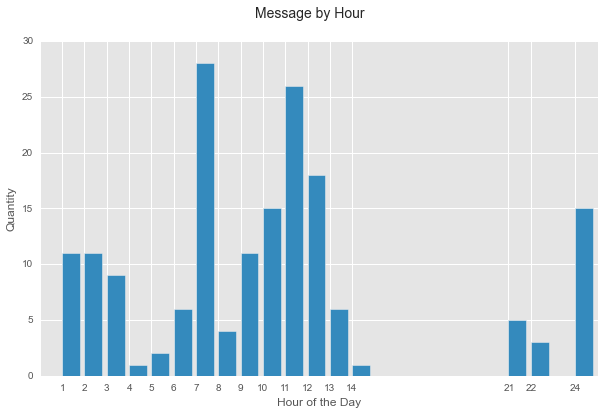

In [167]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.bar(jared.groupby(jared.ts.apply(lambda x: x.hour)).text.size().index +1,jared.groupby(jared.ts.apply(lambda x: x.hour)).text.size())
fig.suptitle("Message by Hour",fontsize= 14)
ax.set_xlabel("Hour of the Day")
ax.set_xticks(jared.groupby(jared.ts.apply(lambda x: x.hour)).text.size().index+ 1)
ax.set_ylabel("Quantity")
#fig.savefig("Aggregated Hours.png")

In [164]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

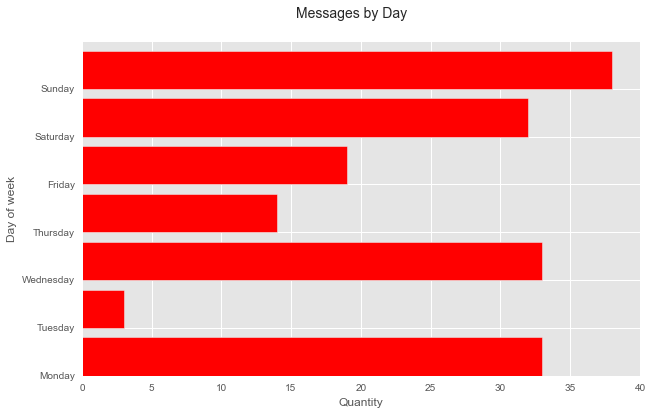

In [168]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.barh(jared.groupby(jared.ts.apply(lambda x: x.dayofweek)).text.size().index +1,jared.groupby(jared.ts.apply(lambda x: x.dayofweek)).text.size(),color='red')
fig.suptitle("Messages by Day",fontsize= 14)
ax.set_ylabel("Day of week")
ax.set_yticklabels(days) #jared.groupby(jared.ts.apply(lambda x: x.dayofweek)).text.size().index+ 1)
ax.set_xlabel("Quantity")
#fig.savefig("Aggregated Day of Week.png")

## Part 7 Sentiment Analysis

In [9]:
from aylienapiclient import textapi

client = textapi.Client("e1bba75f", "a974c3050c2187cffaa9b50451d0c312")

In [10]:
text = 'John is a very good football player'
sentiment = client.Sentiment({'text': text})
print sentiment

{u'polarity': u'positive', u'text': u'John is a very good football player', u'polarity_confidence': 0.8693919697854208, u'subjectivity_confidence': 0.9963778207617525, u'subjectivity': u'subjective'}


In [11]:
print sentiment['polarity']
print sentiment['polarity_confidence']

positive
0.869391969785


In [66]:
polarity = []
polarity_confidence = []


for n in data.clean_text:
    sent = client.Sentiment({'text': n})
    
    polarity.append(sent['polarity_confidence'])
    polarity_confidence.append(sent)


HttpError: <HttpError 429 when requesting https://api.aylien.com/api/v1/sentiment returned "">

In [68]:
len(sentiment)

1000

In [100]:
sent_data = pd.DataFrame(sentiment)

In [101]:
sent_data.head()

,0
0,0.852409
1,0.576838
2,0.854629
3,0.852409
4,0.852409


In [102]:
sent_data.columns = ['polarity_confidence']

In [96]:
sent_data.polarity.value_counts() / len(sent_data)

1    0.866
0    0.134
dtype: float64

In [124]:
sent_data['polarity'] = sent_data.polarity_confidence.apply(lambda x: 1 if x > 0.5 else 0)

In [106]:
sent_data.to_csv("Sentiment_output",encoding='utf-8')

In [126]:
sent_data.head(10)

,polarity_confidence,polarity
0,0.852409,1
1,0.576838,1
2,0.854629,1
3,0.852409,1
4,0.852409,1
5,0.852409,1
6,0.692458,1
7,0.834836,1
8,0.832721,1
9,0.788597,1


In [135]:
test = pd.concat([data,sent_data],axis=1)
test.head()

,user,ts,channel,text,name,clean_text,polarity_confidence,polarity
0,U0WEAA087,2016-04-03 23:32:26.000002,36100-dsi,<@U0WEAA087|jared> has joined the channel,jared,DataScientist joined,0.852409,1
1,U0WEAA087,2016-04-03 23:32:27.000003,36100-dsi,<@U0WEAA087|jared> set the channel purpose: Ch...,jared,DataScientist set purpose dedicated data scien...,0.576838,1
2,U0WEAA087,2016-04-04 10:24:28.000009,36100-dsi,Yeah trying to get it done. I'm hoping to smas...,jared,yeah trying get done m hoping smash wednesday ...,0.854629,1
3,U0WEAA087,2016-04-11 06:07:57.000119,36100-dsi,"Hey Guys, sorry haven't been that active. I'm ...",jared,hey guy sorry haven active m fine excel knime ...,0.852409,1
4,U0WEAA087,2016-04-11 06:11:39.000120,36100-dsi,<http://nicomiceli.com/slackalytics/> I might ...,jared,Sharing might look,0.852409,1


In [137]:
data.sort('ts',ascending=False)

,user,ts,channel,text,name,clean_text
1611,U0WFHMEM8,2016-05-08 22:30:38.000054,general,"Hi Ravi, welcome to the group..!",hussam,hi Consultant welcome group
2842,U0X6CUQ3D,2016-05-08 22:25:43.000053,general,Although howdy is a bit of a renegade maverick...,martinlehmann,although BendertheScrumMaster bit renegade mav...
2841,U0X6CUQ3D,2016-05-08 22:25:02.000052,general,Forgot to introduce you to <@U13AJ8EVD> also,martinlehmann,forgot introduce BendertheScrumMaster also
2840,U0X6CUQ3D,2016-05-08 22:24:40.000051,general,Hi Ravi! Welcome aboard! <@U0X443CKZ> <@U0WDYE...,martinlehmann,hi Consultant welcome aboard DataScientist Bus...
1377,U0WFHMEM8,2016-05-08 21:22:40.000020,crisp-businessknow,I will have a look and provide feedback tonight,hussam,look provide feedback tonight
1319,U0WFHMEM8,2016-05-08 21:15:01.000208,36100-dsi,"Martin, you are right, this week is crucial ...",hussam,ProjectManager right week crucial
1318,U0WFHMEM8,2016-05-08 21:14:10.000207,36100-dsi,Nice job Duhita..!,hussam,nice job BusinessAnalyst
2938,U173EGY2E,2016-05-08 15:58:59.000050,general,Thanks for adding to the group,ravi,thanks adding group
2937,U173EGY2E,2016-05-08 15:58:53.000049,general,"Hi Team,",ravi,hi team
2936,U173EGY2E,2016-05-08 15:55:08.000048,general,<@U173EGY2E|ravi> has joined the channel,ravi,u egy e Consultant joined
